In [1]:
#importing libraries
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
from sklearn.linear_model import TweedieRegressor
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
#import mlflow

In [3]:
# Load data
location = 'C:/Users/pranshuk/OneDrive - Logic20 20 Inc/Desktop/EC Prediction Data/New EC Data/data_w_geo_predictors_proj_level_kc.xlsx'
data = pd.read_excel(location)

In [4]:
#display rows
data.head()

,proj_cd,por_id,site_region_name,site_mkt_name,site_cty_name,site_county_name,site_addr_desc,site_type_desc,site_class_desc,Siterra_And_elemenT_Structure_Owner,...,awater,intptlat,intptlon,Universe_geometry_k,SITETYPE,LEVY_JURIS,PROPTYPE,KCA_ZONING,PREUSE_COD,PREUSE_DES
0,SE04035A - Site Modification (4902665),"POR0348914,POR0256248",WEST,SEATTLE WA,Renton,King,3401 Lind Avenue SW,Structure Non Building,Monopole,Crown Castle T3,...,4544405.0,47.479191,-122.194613,73e4ab58f0aed3fd,C9,RENTON,C,IL,195.0,Warehouse
1,SE01130C - Site Modification (4902594),POR0256260,WEST,SEATTLE WA,Seattle,King,9725 3rd Avenue NE,Building,Roof Top Mount,"US Wireless, Inc.",...,150761136.0,47.619349,-122.351471,5b1ccf47ec6f6313,C1,SEATTLE,C,SM-NG 145,106.0,Office Building
2,SE02108E - Site Modification (4946325),"POR0307721,POR0254995,POR0327285",WEST,SEATTLE WA,Seattle,King,3206 SW Admiral Way,Structure Non Building,Wood Pole,City of Seattle,...,150761136.0,47.619349,-122.351471,5b1ccf47ec6f6313,NaN,NaN,NaN,NaN,NaN,NaN
3,SE03559F - Site Modification (4902649),"POR0260721,POR0308045",WEST,SEATTLE WA,Tukwila,King,4030 S. 140th St,Structure Non Building,Wood Pole,City of Seattle,...,1069363.0,47.476289,-122.275740,9b2abbc615945874,R2,TUKWILA,C,HDR,11.0,Apartment
4,SE02339D - Site Modification (4902627),POR0256254,WEST,SEATTLE WA,Redmond,King,18609 NE 65th Street,Structure Non Building,Watertank,City of Redmond,...,1732419.0,47.677925,-122.115336,43129f32c57993d3,U1,REDMOND,C,MP,266.0,"Utility, Public"


In [5]:
#data dimensions
data.shape

(449, 133)

### Data Cleansing

In [9]:
#store column names
data_cols = data.columns

In [10]:
#storing columns with null values separately
isnull_cols = {}
for feature in data_cols:
    if data[feature].isnull().sum() > 0:
        isnull_cols[feature] = data[feature].isnull().sum()

In [11]:
#dictionary containing null counts 
isnull_cols

{'min_por_plan_status_dt': 40,
 'max_por_plan_status_dt': 40,
 'Min_HC_Release_POR': 25,
 'id': 60,
 'frm_apn': 60,
 'orig_apn': 60,
 'land_use': 60,
 'land_use_name': 65,
 'prop_ind': 60,
 'property_indicator_name': 60,
 'zoning': 60,
 'tax_yr': 61,
 'tax_amt': 61,
 'tot_val': 122,
 'imp_val': 160,
 'lan_val': 123,
 'imp_land_ratio': 161,
 'land_value_assessment_type': 60,
 'total_value_assessment_type': 60,
 'mkt_imp': 160,
 'mkt_lan': 123,
 'mkt_val': 122,
 'mkt_imp_land_ratio': 161,
 'assd_imp': 160,
 'assd_lan': 123,
 'assd_val': 122,
 'assd_imp_land_ratio': 161,
 'yr_blt': 152,
 'eff_yr_blt': 187,
 'bld_units': 96,
 'units_nbr': 378,
 'land_acres': 60,
 'land_sq_ft': 60,
 'bld_sq_ft': 164,
 'bldg_far': 164,
 'ubld_sq_ft': 153,
 'adj_sq_ft': 204,
 'bsmt_sq_ft': 430,
 'front_ft': 449,
 'depth_ft': 449,
 'gf_sq_ft': 409,
 'pool': 434,
 'energy_use_type': 449,
 'water_type': 73,
 'fuel_type': 449,
 'sewer_type': 449,
 'std_addr': 102,
 'std_state': 102,
 'std_zip': 102,
 'census_tr':

In [12]:
# calculating missing values percentage
percent_missing = data.isnull().sum() / len(data) * 100

In [13]:
percent_missing

proj_cd              0.000000
por_id               0.000000
site_region_name     0.000000
site_mkt_name        0.000000
site_cty_name        0.000000
                      ...    
LEVY_JURIS          19.153675
PROPTYPE            13.140312
KCA_ZONING          13.140312
PREUSE_COD          13.140312
PREUSE_DES          14.922049
Length: 133, dtype: float64

In [14]:
#checking datatypes
data.dtypes

proj_cd              object
por_id               object
site_region_name     object
site_mkt_name        object
site_cty_name        object
                     ...   
LEVY_JURIS           object
PROPTYPE             object
KCA_ZONING           object
PREUSE_COD          float64
PREUSE_DES           object
Length: 133, dtype: object

In [15]:
#Final features for the dataset
data_v1 = data[['site_type_desc','site_class_desc','MLA_Partner','MLA_Flag','isurban','EC Duration',
            'Category_v_Anchor','Category_v_L600','Category_v_Capacity_Other','max_proj_l600_flg','max_proj_2500_flg',
            'land_use_name','property_indicator_name','tax_amt','yr_blt','land_acres','std_city']]

In [17]:
data_v1['EC Duration'].dtype

dtype('float64')

In [16]:
data_v1

,site_type_desc,site_class_desc,MLA_Partner,MLA_Flag,isurban,EC Duration,Category_v_Anchor,Category_v_L600,Category_v_Capacity_Other,max_proj_l600_flg,max_proj_2500_flg,land_use_name,property_indicator_name,tax_amt,yr_blt,land_acres,std_city
0,Structure Non Building,Monopole,Other,Y,1,5.9,1,0,1,0,1,WAREHOUSE,WAREHOUSE,206166.61,1986.0,5.1496,RENTON
1,Building,Roof Top Mount,Other,N,1,8.8,1,0,0,0,1,OFFICE BUILDING,OFFICE BUILDING,258186.06,1979.0,3.2108,SEATTLE
2,Structure Non Building,Wood Pole,Other,N,1,12.7,1,1,1,1,1,NaN,NaN,NaN,NaN,NaN,SEATTLE
3,Structure Non Building,Wood Pole,Other,N,1,10.6,1,1,0,1,1,APARTMENT,APARTMENT,5630.69,NaN,0.3857,TUKWILA
4,Structure Non Building,Watertank,Other,N,1,4.6,1,0,0,0,1,UTILITIES,UTILITIES,17.63,NaN,0.8844,REDMOND
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
444,Structure Non Building,Utility Lattice Tower,Other,N,1,6.1,0,1,0,1,0,NaN,MISCELLANEOUS,11.89,NaN,0.2415,RENTON
445,Structure Non Building,Self Support Tower,Crown Castle,Y,0,8.6,1,0,0,0,1,RESIDENTIAL ACREAGE,VACANT,283.12,NaN,49.2300,FALL CITY
446,Building,Roof Top Mount,Other,N,1,5.1,1,0,1,0,1,TECHNOLOGICAL INDUSTRY,INDUSTRIAL,161150.33,1987.0,4.3243,BOTHELL
447,Building,In Building,Other,N,1,0.9,0,0,1,0,0,PARKING STRUCTURE,PARKING,22906.58,NaN,0.7920,BELLEVUE


In [18]:
#separating categorical features in the dataset
categorical_features = [column_name for column_name in data_v1.columns if data_v1[column_name].dtype == 'O']
print('Number of categorical features: {}'.format(len(categorical_features)))
print('Categorical features: {}'.format(list(categorical_features)))

Number of categorical features: 7
Categorical features: ['site_type_desc', 'site_class_desc', 'MLA_Partner', 'MLA_Flag', 'land_use_name', 'property_indicator_name', 'std_city']


In [19]:
#Separating numerical features in the dataset
numerical_features = [column_name for column_name in data_v1.columns if data_v1[column_name].dtype != 'O']
print('Number of numerical features: {}'.format(len(numerical_features)))
print('Numerical Features:', list(numerical_features))

Number of numerical features: 10
Numerical Features: ['isurban', 'EC Duration', 'Category_v_Anchor', 'Category_v_L600', 'Category_v_Capacity_Other', 'max_proj_l600_flg', 'max_proj_2500_flg', 'tax_amt', 'yr_blt', 'land_acres']


In [20]:
#checking cardinality
for each_feature in categorical_features:
    unique_values = len(data[each_feature].unique())
    print('{} : {}'.format(each_feature, unique_values))

site_type_desc : 2
site_class_desc : 14
MLA_Partner : 3
MLA_Flag : 2
land_use_name : 57
property_indicator_name : 24
std_city : 36


#### Handling Missing Values

In [22]:
#checking null values
data_v1.isnull().sum()

site_type_desc                 0
site_class_desc                0
MLA_Partner                    0
MLA_Flag                       0
isurban                        0
EC Duration                    0
Category_v_Anchor              0
Category_v_L600                0
Category_v_Capacity_Other      0
max_proj_l600_flg              0
max_proj_2500_flg              0
land_use_name                 65
property_indicator_name       60
tax_amt                       61
yr_blt                       152
land_acres                    60
std_city                       0
dtype: int64

In [ ]:
# pip install sweetviz
# Importing Sweetviz for analysis
import sweetviz as sv

In [ ]:
#generating report around data 
report = sv.analyze(source=data_v1,target_feat='EC Duration', pairwise_analysis='on')
report.show_html('EC_v1_Analysis.html')

In [23]:
# substituting null values with the majority class 'APARTMENT'
data_v1['land_use_name'].fillna('APARTMENT', inplace = True)

C:\Users\pranshuk\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [24]:
# substituting null values with the majority class 'APARTMENT'
data_v1['property_indicator_name'].fillna('APARTMENT', inplace = True)

In [25]:
data_v1.isnull().sum()

site_type_desc                 0
site_class_desc                0
MLA_Partner                    0
MLA_Flag                       0
isurban                        0
EC Duration                    0
Category_v_Anchor              0
Category_v_L600                0
Category_v_Capacity_Other      0
max_proj_l600_flg              0
max_proj_2500_flg              0
land_use_name                  0
property_indicator_name        0
tax_amt                       61
yr_blt                       152
land_acres                    60
std_city                       0
dtype: int64

#### Outlier Identification and Treatment

C:\Users\pranshuk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='tax_amt'>

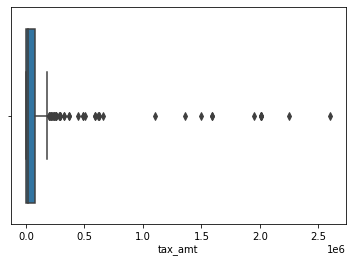

In [26]:
#using boxplot to visualize outliers
sns.boxplot(data_v1['tax_amt'])

C:\Users\pranshuk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='yr_blt'>

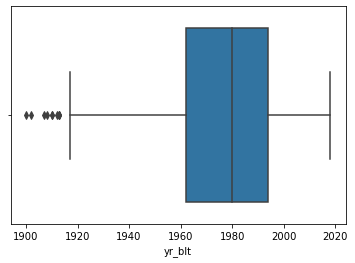

In [27]:
sns.boxplot(data_v1['yr_blt'])

C:\Users\pranshuk\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='land_acres'>

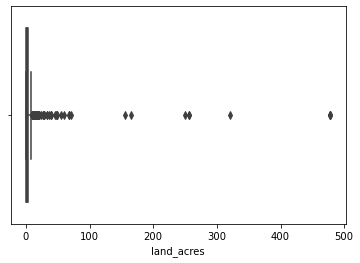

In [28]:
sns.boxplot(data_v1['land_acres'])


In [29]:
#Outliers Treatment

features_with_outliers = ['tax_amt','yr_blt','land_acres']
for feature in features_with_outliers:
    q1 = data_v1[feature].quantile(.25)
    q3 = data_v1[feature].quantile(.75)
    IQR = q3 - q1
    lower_limit = q1 - (IQR*1.5)
    upper_limit = q3 + (IQR*1.5)
    data_v1.loc[data_v1[feature] < lower_limit, feature] = lower_limit
    data_v1.loc[data_v1[feature] > upper_limit, feature] = upper_limit

C:\Users\pranshuk\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


Since we have treated outliers successfully, it should be safe to impute missing values using 'mean'

In [30]:
#treating null values with 'median' value due to the presence of outliers
data_v1['tax_amt'].fillna(data_v1['tax_amt'].mean(), inplace = True)
data_v1['yr_blt'].fillna(data_v1['tax_amt'].mean(), inplace = True)
data_v1['land_acres'].fillna(data_v1['land_acres'].mean(), inplace = True)

C:\Users\pranshuk\anaconda3\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


In [31]:
#confirming null values
data_v1[['tax_amt','yr_blt','land_acres']].isnull().sum()

tax_amt       0
yr_blt        0
land_acres    0
dtype: int64

#### One-hot Encoding

In [32]:
data_v1_oh = data_v1.copy()

data_v1_oh = pd.get_dummies(data_v1_oh, columns= ['site_type_desc', 'site_class_desc', 'MLA_Partner', 'MLA_Flag', 'land_use_name', 'property_indicator_name', 'std_city'])

#### Separating Target and Features

In [35]:
X = data_v1_oh.drop(['EC Duration'], axis = 1)
y = data_v1_oh['EC Duration']

### Model Training

#### Evaluating Model Performance

#### Feature Importance
We will be using ExtraTreesRegressor class for Feature Importance. This class implements a meta estimator that fits a number of randomized decision trees on various samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.

In [36]:
from sklearn.ensemble import ExtraTreesRegressor
etr_model = ExtraTreesRegressor()
etr_model.fit(X, y)
etr_model.feature_importances_

array([9.28749611e-03, 1.11471831e-01, 2.47644643e-02, 1.04786373e-02,
       2.53342219e-02, 8.40927848e-02, 6.69838530e-02, 7.64196561e-02,
       4.29648373e-02, 2.59834949e-03, 2.44471839e-03, 4.50976778e-04,
       1.79876031e-04, 1.59873125e-02, 5.66174890e-03, 5.47851013e-03,
       2.20235775e-02, 2.52942758e-04, 6.39054651e-04, 2.96097704e-05,
       4.41755203e-03, 4.10459248e-03, 3.72337368e-03, 3.73292398e-03,
       1.98877008e-02, 1.92874744e-02, 3.41397154e-03, 3.63098123e-03,
       3.75208720e-03, 4.09635449e-03, 1.28732762e-02, 9.69812255e-05,
       2.03512451e-03, 1.75770063e-04, 4.37358231e-06, 4.12802793e-03,
       1.03149267e-03, 3.40012339e-03, 8.20950700e-03, 2.07417806e-03,
       2.24434892e-03, 2.32198854e-04, 1.58433801e-05, 2.79712776e-05,
       7.35390304e-05, 2.99644497e-04, 1.73498287e-03, 3.14319737e-05,
       2.26056589e-03, 1.21643387e-03, 7.41662085e-04, 1.57128533e-03,
       1.01047208e-02, 1.25366302e-02, 1.52917178e-02, 1.52211844e-03,
      

<AxesSubplot:>

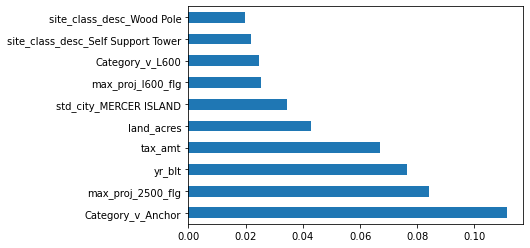

In [37]:
feature_imp = pd.Series(etr_model.feature_importances_, index = X.columns)
feature_imp.nlargest(10).plot(kind = 'barh')

#### Splitting Data into Training and Testing Set

In [38]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

#### Feature Scaling

In [39]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [40]:
# Fitting Random Forest Regressor to the dataset
# import the regressor
from sklearn.ensemble import RandomForestRegressor

# create regressor object
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
 
# fit the regressor with x and y data
regressor.fit(X_train_scaled, y_train) 

RandomForestRegressor(random_state=0)

In [41]:
# scaling test data and making predictions
X_test_scaled = scaler.transform(X_test)
y_pred = regressor.predict(X_test_scaled)

In [44]:
y_pred.dtype

dtype('float64')

In [48]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

ValueError: continuous is not supported

In [43]:
#Cross Validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regressor, X_train_scaled, y_train, cv = 10, scoring = 'accuracy')
print('Cross-validation scores: {}'.format(scores))
print('Average cross-validation score: {}'.format(scores.mean()))

C:\Users\pranshuk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pranshuk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\pranshuk\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\pranshuk\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\pranshuk\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\pranshuk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred 

Cross-validation scores: [nan nan nan nan nan nan nan nan nan nan]
Average cross-validation score: nan


C:\Users\pranshuk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:696: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\pranshuk\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 687, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\pranshuk\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Users\pranshuk\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Users\pranshuk\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Users\pranshuk\anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred 